<a href="https://colab.research.google.com/github/skidbyandy/fintw/blob/main/%E3%80%8CStock_Fundamental_ipynb%E3%80%8D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/tutorials/1-Introduction/Stock_Fundamental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock trading with fundamentals

* This notebook is based on the tutorial: https://towardsdatascience.com/finrl-for-quantitative-finance-tutorial-for-multiple-stock-trading-7b00763b7530

* This project is a result of the almuni-mentored research project at Columbia University, Application of Reinforcement Learning to Finance.
* For detailed explanation, please check out the Medium article: https://medium.com/@mariko.sawada1/automated-stock-trading-with-deep-reinforcement-learning-and-financial-data-a63286ccbe2b



In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Content

* [1. Task Discription](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess fundamental Data](#3)        
    * [4.1 Import financial data](#3.1)
    * [4.2 Specify items needed to calculate financial ratios](#3.2)
    * [4.3 Calculate financial ratios](#3.3)
    * [4.4 Deal with NAs and infinite values](#3.4)
    * [4.5 Merge stock price data and ratios into one dataframe](#3.5)
    * [4.6 Calculate market valuation ratios using daily stock price data](#3.6)
* [5. Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6. Train DRL Agents](#5)  
* [7. Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Task Description

We train a DRL agent for stock trading. The task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Like a human trader analyzes various information, here our agent passively observes many features and learn by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data of the single stock that we will use for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close prices and volume.


In [ ]:
#@title load finmind
! pip install FinMind
import numpy as np
import pandas as pd
from FinMind import strategies
from FinMind.data import DataLoader
from FinMind.strategies.base import Strategy
from ta.momentum import StochasticOscillator

<a id='1'></a>
# Part 2. Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [3]:
## install finrl library
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython~=7.9.0, but you have ipython 7.34.0 which is incompatible.



<a id='1.2'></a>
## 2.2. A List of Python Packages
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


<a id='1.4'></a>
## 2.4. Create Folders

In [5]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Stock Data from Yahoo Finance
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).


In [6]:
#!pip install tqdm
from tqdm import tqdm
api = DataLoader()
# api.login_by_token(api_token='token')
# api.login(user_id='user_id',password='password')
sid="2330"
listofsid=["2330","1101","1216","1301","1303","1326","1590","2002","2207","2227","2303","2308","2327","2352","2357","2379","2382","2395","2408","2409","2412","2454","2801","2880","2881","2882","2883","2884","2885","2886","2887","2891","2892","2912","3008","3034","3037","3045","3711","4904","5871","5876","5880","6415","6505","6770","8046","9910"]
for sid in tqdm(listofsid):
  dftemp1 = api.taiwan_stock_financial_statement(
      stock_id=sid,
      start_date = '2019-01-01',
      end_date = '2021-01-01',
  )
  #dftemp1.head()
  dftemp1=dftemp1.pivot_table(index='date',columns ='type')
  dftemp1=dftemp1.sort_index()
  dftemp1.columns = dftemp1.columns.droplevel()
  dftemp1['date']=dftemp1.index
  dftemp1=dftemp1.reset_index(drop=True)
  list(dftemp1.columns)
  dftemp1.head()
  dftemp2=api.taiwan_stock_balance_sheet(
      stock_id=sid,
      start_date = '2019-01-01',
      end_date = '2021-01-01',
  )
  dftemp2=dftemp2.pivot_table(index='date',columns ='type')
  dftemp2=dftemp2.sort_index()
  dftemp2.columns = dftemp2.columns.droplevel()
  dftemp2['date']=dftemp2.index
  dftemp2=dftemp2.reset_index(drop=True)
  list(dftemp2.columns)
  dftemp3=api.taiwan_stock_dividend(
      stock_id=sid,
      start_date = '2019-01-01',
      end_date = '2021-01-01',
  )
  #dftemp3=dftemp3.pivot_table(index='date',columns ='type')
  #dftemp3=dftemp3.sort_index()
  #dftemp3.columns = dftemp3.columns.droplevel()
  list(dftemp3.columns)
  dftemp4=pd.merge(dftemp1, dftemp2, on='date',how='outer')
  dftemp4=pd.merge(dftemp4, dftemp3, on='date', how='outer')
  dftemp4['tic']=sid
  if sid=="2330":
    dftemp5=dftemp4
  else:  
    dftemp5=pd.concat([dftemp5,dftemp4])
  #########################################################
  dftemp0 = api.taiwan_stock_daily(
    stock_id=sid,
    start_date='2019-01-01',
    end_date='2021-01-01'
  )
  dftemp0 = dftemp0.rename(columns={
    'date':'date', # Date
    'stock_id':'tic', # Quarterly operating income
    'Trading_money':'volume', # Quartely revenue
    'max':'high', # Quartely net income
    'min':'low', # Assets
  })
  if sid=="2330":
    df=dftemp0
  else:  
    df=pd.concat([df,dftemp0])
df['date']= pd.to_datetime(df['date'])

 94%|█████████▍| 45/48 [02:24<00:09,  3.20s/it]


KeyError: ignored

In [ ]:
dftemp5=dftemp5.sort_values(by=['date','tic'])
with pd.option_context('display.max_rows', None):
  display(dftemp5[['CurrentAssets','tic','date']])

In [ ]:
#@title itemrem
'''items = [
    'datadate' date, # Date
    **'tic', tic# Ticker
    'oiadpq', OperatingIncome# Quarterly operating income
    'revtq', Revenue# Quartely revenue
    'niq', NetIncome# Quartely net income
    'atq', TotalAssets# Total asset
    'teqq', *EquityAttributableToOwnersOfParent# Shareholder's equity
    'epspiy', EPS# EPS(Basic) incl. Extraordinary items
    'ceqq', Equity# Common Equity
    'cshoq', OrdinaryShare# Common Shares Outstanding
    'dvpspq', CashEarningsDistribution# Dividends per share
    'actq', TotalAssets# Current assets
    'lctq', CurrentLiabilities# Current liabilities
    'cheq', CashAndCashEquivalents# Cash & Equivalent
    'rectq', AccountsReceivableNet# Recievalbles
    'cogsq', CostOfGoodsSold# Cost of  Goods Sold
    'invtq', Inventories# Inventories
    'apq',AccountsPayable# AccountsPayableAccount payable
    'dlttq', LongtermBorrowings# Long term debt
    'dlcq', *CurrentLiabilities# Debt in current liabilites
    'ltq' Liabilities# Liabilities   
]
'''

In [ ]:
items = [
     'date' # Date
    , 'tic'# Ticker
    , 'OperatingIncome'# Quarterly operating income
    , 'Revenue'# Quartely revenue
    , 'NetIncome'# Quartely net income
    , 'TotalAssets'# Total asset
    , 'EquityAttributableToOwnersOfParent_y'#%%Shareholder's equity
    , 'EPS'# EPS(Basic) incl. Extraordinary items
    , 'Equity'# Common Equity
    , 'OrdinaryShare'# Common Shares Outstanding
    , 'CashEarningsDistribution'#' Dividends per share
    , 'CurrentAssets'# Current assets
    , 'CurrentLiabilities'# Current liabilities
    , 'CashAndCashEquivalents'# Cash & Equivalent
    , 'AccountsReceivableNet'#' Recievalbles
    , 'CostOfGoodsSold'# Cost of  Goods Sold
    , 'Inventories'# Inventories
    , 'AccountsPayable'# AccountsPayableAccount payable
    , 'LongtermBorrowings'# Long term debt
    , 'ShorttermBorrowings'#%% Debt in current liabilites
    , 'Liabilities'# Liabilities      
]
fund_data=dftemp5[items]

In [ ]:
fund_data = fund_data.rename(columns={
    'CurrentAssets':'cur_assets', # Current assets
    'OperatingIncome':'op_inc_q', # Quarterly operating income
    'Revenue':'rev_q', # Quartely revenue
    'NetIncome':'net_inc_q', # Quartely net income
    'TotalAssets':'tot_assets', # Assets
    'EquityAttributableToOwnersOfParent_y':'sh_equity', # Shareholder's equity
    'EPS':'eps_incl_ex', # EPS(Basic) incl. Extraordinary items
    'Equity':'com_eq', # Common Equity
    'OrdinaryShare':'sh_outstanding', # Common Shares Outstanding
    'CashEarningsDistribution':'div_per_sh', # Dividends per share
    'CurrentLiabilities':'cur_liabilities', # Current liabilities
    'CashAndCashEquivalents':'cash_eq', # Cash & Equivalent
    'AccountsReceivableNet':'receivables', # Receivalbles
    'CostOfGoodsSold':'cogs_q', # Cost of  Goods Sold
    'Inventories':'inventories', # Inventories
    'AccountsPayable': 'payables',# Account payable
    'LongtermBorrowings':'long_debt', # Long term debt
    'ShorttermBorrowings':'short_debt', # Debt in current liabilites
    'Liabilities':'tot_liabilities' # Liabilities   
})
fund_data=fund_data.reset_index()

# Part 4: Preprocess fundamental data
- Import finanical data downloaded from Compustat via WRDS(Wharton Research Data Service)
- Preprocess the dataset and calculate financial ratios
- Add those ratios to the price data preprocessed in Part 3
- Calculate price-related ratios such as P/E and P/B

## 4.1 Import the financial data

## 4.2 Specify items needed to calculate financial ratios
- To learn more about the data description of the dataset, please check WRDS's website(https://wrds-www.wharton.upenn.edu/). Login will be required.

## 4.3 Calculate financial ratios
- For items from Profit/Loss statements, we calculate LTM (Last Twelve Months) and use them to derive profitability related ratios such as Operating Maring and ROE. For items from balance sheets, we use the numbers on the day.
- To check the definitions of the financial ratios calculated here, please refer to CFI's website: https://corporatefinanceinstitute.com/resources/knowledge/finance/financial-ratios/

In [ ]:
# Calculate financial ratios
date = pd.to_datetime(fund_data['date'],format='%Y-%m-%d')

tic = fund_data['tic'].to_frame('tic')

# Profitability ratios
# Operating Margin
OPM = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='OPM')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        OPM[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        OPM.iloc[i] = np.nan
    else:
        OPM.iloc[i] = np.sum(fund_data['op_inc_q'].iloc[i-3:i])/np.sum(fund_data['rev_q'].iloc[i-3:i])

# Net Profit Margin        
NPM = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='NPM')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        NPM[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        NPM.iloc[i] = np.nan
    else:
        NPM.iloc[i] = np.sum(fund_data['net_inc_q'].iloc[i-3:i])/np.sum(fund_data['rev_q'].iloc[i-3:i])

# Return On Assets
ROA = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='ROA')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        ROA[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        ROA.iloc[i] = np.nan
    else:
        ROA.iloc[i] = np.sum(fund_data['net_inc_q'].iloc[i-3:i])/fund_data['tot_assets'].iloc[i]

# Return on Equity
ROE = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='ROE')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        ROE[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        ROE.iloc[i] = np.nan
    else:
        ROE.iloc[i] = np.sum(fund_data['net_inc_q'].iloc[i-3:i])/fund_data['sh_equity'].iloc[i]        

# For calculating valuation ratios in the next subpart, calculate per share items in advance
# Earnings Per Share       
EPS = fund_data['eps_incl_ex'].to_frame('EPS')

# Book Per Share
BPS = (fund_data['com_eq']/fund_data['sh_outstanding']).to_frame('BPS') # Need to check units

#Dividend Per Share
DPS = fund_data['div_per_sh'].to_frame('DPS')

# Liquidity ratios
# Current ratio
cur_ratio = (fund_data['cur_assets']/fund_data['cur_liabilities']).to_frame('cur_ratio')

# Quick ratio
quick_ratio = ((fund_data['cash_eq'] + fund_data['receivables'] )/fund_data['cur_liabilities']).to_frame('quick_ratio')

# Cash ratio
cash_ratio = (fund_data['cash_eq']/fund_data['cur_liabilities']).to_frame('cash_ratio')


# Efficiency ratios
# Inventory turnover ratio
inv_turnover = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='inv_turnover')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        inv_turnover[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        inv_turnover.iloc[i] = np.nan
    else:
        inv_turnover.iloc[i] = np.sum(fund_data['cogs_q'].iloc[i-3:i])/fund_data['inventories'].iloc[i]

# Receivables turnover ratio       
acc_rec_turnover = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='acc_rec_turnover')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        acc_rec_turnover[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        acc_rec_turnover.iloc[i] = np.nan
    else:
        acc_rec_turnover.iloc[i] = np.sum(fund_data['rev_q'].iloc[i-3:i])/fund_data['receivables'].iloc[i]

# Payable turnover ratio
acc_pay_turnover = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='acc_pay_turnover')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        acc_pay_turnover[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        acc_pay_turnover.iloc[i] = np.nan
    else:
        acc_pay_turnover.iloc[i] = np.sum(fund_data['cogs_q'].iloc[i-3:i])/fund_data['payables'].iloc[i]
        
## Leverage financial ratios
# Debt ratio
debt_ratio = (fund_data['tot_liabilities']/fund_data['tot_assets']).to_frame('debt_ratio')

# Debt to Equity ratio
debt_to_equity = (fund_data['tot_liabilities']/fund_data['sh_equity']).to_frame('debt_to_equity')

In [ ]:
# Create a dataframe that merges all the ratios
ratios = pd.concat([date,tic,OPM,NPM,ROA,ROE,EPS,BPS,DPS,
                    cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,
                   debt_ratio,debt_to_equity], axis=1)

In [ ]:
# Check the ratio data
ratios.head()

In [ ]:
ratios.tail()

## 4.4 Deal with NAs and infinite values
- We replace N/A and infinite values with zero.

In [ ]:
# Replace NAs infinite values with zero
final_ratios = ratios.copy()
final_ratios = final_ratios.fillna(0)
final_ratios = final_ratios.replace(np.inf,0)

In [ ]:
final_ratios.head()

In [ ]:
final_ratios.tail()

In [ ]:
df.sort_values(by=['tic'])

In [ ]:
df['date']= pd.to_datetime(df['date'])

In [ ]:
final_ratios.shape

## 4.5 Merge stock price data and ratios into one dataframe
- Merge the price dataframe preprocessed in Part 3 and the ratio dataframe created in this part
- Since the prices are daily and ratios are quartely, we have NAs in the ratio columns after merging the two dataframes. We deal with this by backfilling the ratios.

In [ ]:
import itertools
list_ticker = df["tic"].unique().tolist()
list_date = list(pd.date_range(df['date'].min(),df['date'].max()))
combination = list(itertools.product(list_date,list_ticker))

# Merge stock price data and ratios into one dataframe
processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(df,on=["date","tic"],how="left")
processed_full = processed_full.merge(final_ratios,how='left',on=['date','tic'])
processed_full = processed_full.sort_values(['tic','date'])

# Backfill the ratio data to make them daily
processed_full = processed_full.ffill(axis='rows')
processed_full = processed_full.bfill(axis='rows')


## 4.6 Calculate market valuation ratios using daily stock price data 

In [ ]:
# Calculate P/E, P/B and dividend yield using daily closing price
processed_full['PE'] = processed_full['close']/processed_full['EPS']
processed_full['PB'] = processed_full['close']/processed_full['BPS']
processed_full['Div_yield'] = processed_full['DPS']/processed_full['close']

# Drop per share items used for the above calculation
processed_full = processed_full.drop(columns=['EPS','BPS','DPS'])#delete day
# Replace NAs infinite values with zero
processed_full = processed_full.copy()
processed_full = processed_full.fillna(0)
processed_full = processed_full.replace(np.inf,0)

In [ ]:
# Check the final data
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

<a id='4'></a>
# Part 5. A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## 5.1 Data Split
- Training data period: 2009-01-01 to 2019-01-01
- Trade data period: 2019-01-01 to 2020-12-31

In [ ]:
train_data = data_split(processed_full, '2010-01-01','2019-12-31')
trade_data = data_split(processed_full, '2019-12-31','2021-12-01')
# Check the length of the two datasets
print(len(train_data))
print(len(trade_data))

54765
5505


In [ ]:
train_data.head()

,date,tic,Trading_Volume,volume,open,high,low,close,spread,Trading_turnover,...,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity,PE,PB,Div_yield
0,2010-01-01,1101,10271721.0,3.497109e+08,34.1,34.25,33.95,34.0,0.0,3150.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,43.589744,0.000000,0.0
0,2010-01-01,1303,5755569.0,3.347552e+08,58.1,58.30,57.80,58.3,0.2,1950.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,61.368421,0.000000,0.0
0,2010-01-01,1590,6469210.0,4.659489e+08,72.1,72.70,71.60,71.9,-0.6,3059.0,...,0.824984,0.466885,0.0,0.0,0.0,0.0,0.0,46.993464,15.991242,0.0
0,2010-01-01,2317,20781791.0,3.124923e+09,150.0,151.50,149.50,151.5,2.0,8289.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,44.690265,0.000000,0.0
0,2010-01-01,2330,52178759.0,3.355553e+09,64.4,64.50,63.90,64.5,0.6,8957.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,51.190476,0.000000,0.0


In [ ]:
trade_data.head()

,date,tic,Trading_Volume,volume,open,high,low,close,spread,Trading_turnover,...,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity,PE,PB,Div_yield
0,2019-12-31,1101,8465583.0,3.696949e+08,43.65,43.8,43.5,43.7,0.05,3374.0,...,0.938052,0.805207,0.000000,0.00000,0.000000,0.432731,0.821033,36.722689,11.876875,0.0
0,2019-12-31,1303,2800232.0,2.040221e+08,72.90,73.1,72.8,72.8,-0.40,868.0,...,0.960874,0.522152,0.000000,0.00000,0.000000,0.358961,0.577842,140.000000,16.237666,0.0
0,2019-12-31,1590,2234796.0,1.031486e+09,448.00,472.0,446.5,466.5,19.50,1861.0,...,0.532701,0.318572,0.000000,0.00000,0.000000,0.544738,1.197159,106.506849,48.476997,0.0
0,2019-12-31,2317,14491239.0,1.317120e+09,90.70,91.4,90.7,90.8,-0.10,6530.0,...,1.113234,0.517577,0.175407,0.11239,0.103907,0.000000,0.000000,26.318841,8.993546,0.0
0,2019-12-31,2330,22950517.0,7.614539e+09,331.00,333.5,331.0,331.0,-3.50,12253.0,...,1.006047,0.770902,20.414125,13.07816,43.692079,0.283782,0.396390,73.883929,52.912768,0.0


## 5.2 Set up the training environment

In [ ]:
import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gym import spaces
from gym.utils import seeding
from stable_baselines3.common.vec_env import DummyVecEnv

matplotlib.use("Agg")

# from stable_baselines3.common import logger


class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df,
        stock_dim,
        hmax,
        initial_amount,
        buy_cost_pct,
        sell_cost_pct,
        reward_scaling,
        state_space,
        action_space,
        tech_indicator_list,
        turbulence_threshold=None,
        risk_indicator_col="turbulence",
        make_plots=True,
        print_verbosity=10,
        day=0,
        initial=True,
        previous_state=[],
        model_name="",
        mode="",
        iteration="",
    ):
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_space,))
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_space,)
        )
        self.data = self.df.loc[self.day, :]
        self.terminal = False
        self.make_plots = make_plots
        self.print_verbosity = print_verbosity
        self.turbulence_threshold = turbulence_threshold
        self.risk_indicator_col = risk_indicator_col
        self.initial = initial
        self.previous_state = previous_state
        self.model_name = model_name
        self.mode = mode
        self.iteration = iteration
        # initalize state
        self.state = self._initiate_state()

        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.episode = 0
        # memorize all the total balance change
        self.asset_memory = [self.initial_amount]
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]
        # self.reset()
        self._seed()

    def _sell_stock(self, index, action):
        def _do_sell_normal():
            if self.state[index + 1] > 0:
                # Sell only if the price is > 0 (no missing data in this particular date)
                # perform sell action based on the sign of the action
                if self.state[index + self.stock_dim + 1] > 0:
                    # Sell only if current asset is > 0
                    sell_num_shares = min(
                        abs(action), self.state[index + self.stock_dim + 1]
                    )
                    sell_amount = (
                        self.state[index + 1]
                        * sell_num_shares
                        * (1 - self.sell_cost_pct)
                    )
                    # update balance
                    self.state[0] += sell_amount

                    self.state[index + self.stock_dim + 1] -= sell_num_shares
                    self.cost += (
                        self.state[index + 1] * sell_num_shares * self.sell_cost_pct
                    )
                    self.trades += 1
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = 0

            return sell_num_shares

        # perform sell action based on the sign of the action
        if self.turbulence_threshold is not None:
            if self.turbulence >= self.turbulence_threshold:
                if self.state[index + 1] > 0:
                    # Sell only if the price is > 0 (no missing data in this particular date)
                    # if turbulence goes over threshold, just clear out all positions
                    if self.state[index + self.stock_dim + 1] > 0:
                        # Sell only if current asset is > 0
                        sell_num_shares = self.state[index + self.stock_dim + 1]
                        sell_amount = (
                            self.state[index + 1]
                            * sell_num_shares
                            * (1 - self.sell_cost_pct)
                        )
                        # update balance
                        self.state[0] += sell_amount
                        self.state[index + self.stock_dim + 1] = 0
                        self.cost += (
                            self.state[index + 1] * sell_num_shares * self.sell_cost_pct
                        )
                        self.trades += 1
                    else:
                        sell_num_shares = 0
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = _do_sell_normal()
        else:
            sell_num_shares = _do_sell_normal()

        return sell_num_shares

    def _buy_stock(self, index, action):
        def _do_buy():
            if self.state[index + 1] > 0:
                # Buy only if the price is > 0 (no missing data in this particular date)
                available_amount = self.state[0] // self.state[index + 1]
                #print('available_amount:{}'.format(available_amount))

                # update balance
                buy_num_shares = min(available_amount, action)
                buy_amount = (
                    self.state[index + 1] * buy_num_shares * (1 + self.buy_cost_pct)
                )
                self.state[0] -= buy_amount

                self.state[index + self.stock_dim + 1] += buy_num_shares

                self.cost += self.state[index + 1] * buy_num_shares * self.buy_cost_pct
                self.trades += 1
            else:
                buy_num_shares = 0

            return buy_num_shares

        # perform buy action based on the sign of the action
        if self.turbulence_threshold is None:
            buy_num_shares = _do_buy()
        else:
            if self.turbulence < self.turbulence_threshold:
                buy_num_shares = _do_buy()
            else:
                buy_num_shares = 0
                pass

        return buy_num_shares

    def _make_plot(self):
        plt.plot(self.asset_memory, "r")
        plt.savefig("drive/MyDrive/A2C/account_value_trade_{}.png".format(self.episode))
        plt.close()

    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique()) - 1
        if self.terminal:
            # print(f"Episode: {self.episode}")
            if self.make_plots:
                self._make_plot()
            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            df_total_value = pd.DataFrame(self.asset_memory)
            tot_reward = (
                self.state[0]
                + sum(
                    np.array(self.state[1 : (self.stock_dim + 1)])
                    * np.array(
                        self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                    )
                )
                - self.initial_amount
            )
            df_total_value.columns = ["account_value"]
            df_total_value["date"] = self.date_memory
            df_total_value["daily_return"] = df_total_value["account_value"].pct_change(
                1
            )
            if df_total_value["daily_return"].std() != 0:
                sharpe = (
                    (252 ** 0.5)
                    * df_total_value["daily_return"].mean()
                    / df_total_value["daily_return"].std()
                )
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.columns = ["account_rewards"]
            df_rewards["date"] = self.date_memory[:-1]
            if self.episode % self.print_verbosity == 0:
                print(f"day: {self.day}, episode: {self.episode}")
                print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
                print(f"end_total_asset: {end_total_asset:0.2f}")
                print(f"total_reward: {tot_reward:0.2f}")
                print(f"total_cost: {self.cost:0.2f}")
                print(f"total_trades: {self.trades}")
                if df_total_value["daily_return"].std() != 0:
                    print(f"Sharpe: {sharpe:0.3f}")
                print("=================================")

            if (self.model_name != "") and (self.mode != ""):
                df_actions = self.save_action_memory()
                df_actions.to_csv(
                    "results/actions_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    )
                )
                df_total_value.to_csv(
                    "results/account_value_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                df_rewards.to_csv(
                    "results/account_rewards_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.plot(self.asset_memory, "r")
                plt.savefig(
                    "results/account_value_{}_{}_{}.png".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.close()

            # Add outputs to logger interface
            # logger.record("environment/portfolio_value", end_total_asset)
            # logger.record("environment/total_reward", tot_reward)
            # logger.record("environment/total_reward_pct", (tot_reward / (end_total_asset - tot_reward)) * 100)
            # logger.record("environment/total_cost", self.cost)
            # logger.record("environment/total_trades", self.trades)

            return self.state, self.reward, self.terminal, {}

        else:

            actions = actions * self.hmax  # actions initially is scaled between 0 to 1
            actions = actions.astype(
                int
            )  # convert into integer because we can't by fraction of shares
            if self.turbulence_threshold is not None:
                if self.turbulence >= self.turbulence_threshold:
                    actions = np.array([-self.hmax] * self.stock_dim)
            begin_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            # print("begin_total_asset:{}".format(begin_total_asset))

            argsort_actions = np.argsort(actions)

            sell_index = argsort_actions[: np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][: np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print(f"Num shares before: {self.state[index+self.stock_dim+1]}")
                # print(f'take sell action before : {actions[index]}')
                actions[index] = self._sell_stock(index, actions[index]) * (-1)
                # print(f'take sell action after : {actions[index]}')
                # print(f"Num shares after: {self.state[index+self.stock_dim+1]}")

            for index in buy_index:
                #print('take buy action: {}'.format(actions[index]))
                actions[index] = self._buy_stock(index, actions[index])

            self.actions_memory.append(actions)

            # state: s -> s+1
            self.day += 1
            self.data = self.df.loc[self.day, :]
            if self.turbulence_threshold is not None:
                if len(self.df.tic.unique()) == 1:
                    self.turbulence = self.data[self.risk_indicator_col]
                elif len(self.df.tic.unique()) > 1:
                    self.turbulence = self.data[self.risk_indicator_col].values[0]
            self.state = self._update_state()

            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            self.asset_memory.append(end_total_asset)
            self.date_memory.append(self._get_date())
            self.reward = end_total_asset - begin_total_asset
            self.rewards_memory.append(self.reward)
            self.reward = self.reward * self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        # initiate state
        self.state = self._initiate_state()

        if self.initial:
            self.asset_memory = [self.initial_amount]
        else:
            previous_total_asset = self.previous_state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(
                    self.previous_state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                )
            )
            self.asset_memory = [previous_total_asset]

        self.day = 0
        self.data = self.df.loc[self.day, :]
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False
        # self.iteration=self.iteration
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]

        self.episode += 1

        return self.state

    def render(self, mode="human", close=False):
        return self.state

    def _initiate_state(self):
        if self.initial:
            # For Initial State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.initial_amount]
                    + self.data.close.values.tolist()
                    + [0] * self.stock_dim
                    + sum(
                        [
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ],
                        [],
                    )
                )
            else:
                # for single stock
                state = (
                    [self.initial_amount]
                    + [self.data.close]
                    + [0] * self.stock_dim
                    + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])
                )
        else:
            # Using Previous State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.previous_state[0]]
                    + self.data.close.values.tolist()
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum(
                        [
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ],
                        [],
                    )
                )
            else:
                # for single stock
                state = (
                    [self.previous_state[0]]
                    + [self.data.close]
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])
                )
        return state

    def _update_state(self):
        if len(self.df.tic.unique()) > 1:
            # for multiple stock
            state = (
                [self.state[0]]
                + self.data.close.values.tolist()
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum(
                    [
                        self.data[tech].values.tolist()
                        for tech in self.tech_indicator_list
                    ],
                    [],
                )
            )

        else:
            # for single stock
            state = (
                [self.state[0]]
                + [self.data.close]
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])
            )
        return state

    def _get_date(self):
        if len(self.df.tic.unique()) > 1:
            date = self.data.date.unique()[0]
        else:
            date = self.data.date
        return date

    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        # print(len(date_list))
        # print(len(asset_list))
        df_account_value = pd.DataFrame(
            {"date": date_list, "account_value": asset_list}
        )
        return df_account_value

    def save_action_memory(self):
        if len(self.df.tic.unique()) > 1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            action_list = self.actions_memory
            df_actions = pd.DataFrame(action_list)
            df_actions.columns = self.data.tic.values
            df_actions.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        else:
            date_list = self.date_memory[:-1]
            action_list = self.actions_memory
            df_actions = pd.DataFrame({"date": date_list, "actions": action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [ ]:
ratio_list = ['Trading_Volume','spread','OPM', 'NPM','ROA', 'ROE', 'cur_ratio', 'quick_ratio', 'cash_ratio', 'inv_turnover','acc_rec_turnover', 'acc_pay_turnover', 'debt_ratio', 'debt_to_equity',
       'PE', 'PB', 'Div_yield']

stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(ratio_list)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 15, State Space: 286


In [ ]:
# Parameters for the environment
env_kwargs = {
    "hmax": 10, 
    "initial_amount": 100000, 
    "buy_cost_pct": 0.001425,
    "sell_cost_pct": 0.003,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": ratio_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-5
    
}

#Establish the training environment using StockTradingEnv() class
e_train_gym = StockTradingEnv(df = train_data, **env_kwargs)

## Environment for Training



In [ ]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [ ]:
# Set up the agent using DRLAgent() class using the environment created in the previous part
agent = DRLAgent(env = env_train)

### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)

### Model 1: PPO

In [ ]:
# agent = DRLAgent(env = env_train)
# PPO_PARAMS = {
#     "n_steps": 2048,
#     "ent_coef": 0.01,
#     "learning_rate": 0.00025,
#     "batch_size": 128,
# }
# model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

In [ ]:
# trained_ppo = agent.train_model(model=model_ppo, 
#                              tb_log_name='ppo',
#                              total_timesteps=50000)

### Model 2: DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg", model_kwargs={"learning_rate": 0.0001})

{'learning_rate': 0.0001}
Using cuda device


In [ ]:
%tensorboard --logdir=logs

UsageError: Line magic function `%tensorboard` not found.


In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                             total_timesteps=50000)

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 72        |
|    time_elapsed    | 202       |
|    total_timesteps | 14604     |
| train/             |           |
|    actor_loss      | -1.38e+05 |
|    critic_loss     | 5.33e+08  |
|    learning_rate   | 0.0001    |
|    n_updates       | 10953     |
|    reward          | -0.006944 |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 67        |
|    time_elapsed    | 433       |
|    total_timesteps | 29208     |
| train/             |           |
|    actor_loss      | -4.24e+04 |
|    critic_loss     | 3.34e+07  |
|    learning_rate   | 0.0001    |
|    n_updates       | 25557     |
|    reward          | -0.006944 |
----------------------------------
day: 3650, episode: 10
begin_total_asset: 100000.00
end_total_asset: 232261.06
total_rewar

### Model 3: A2C


In [ ]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

In [ ]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=150000)

### Model 4: TD3

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
             "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

In [ ]:
trained_td3 = agent.train_model(model=model_td3, 
                            tb_log_name='td3',
                            total_timesteps=30000)

### Model 5: SAC

In [ ]:
# agent = DRLAgent(env = env_train)
# SAC_PARAMS = {
#     "batch_size": 128,
#     "buffer_size": 1000000,
#     "learning_rate": 0.0001,
#     "learning_starts": 100,
#     "ent_coef": "auto_0.1",
# }

# model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

In [ ]:
# trained_sac = agent.train_model(model=model_sac, 
#                              tb_log_name='sac',
#                              total_timesteps=80000)

## Trading
Assume that we have $1,000,000 initial capital at 2019-01-01. We use the DDPG model to trade Dow jones 30 stocks.

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2018-12 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [ ]:
env_kwargs = {
    "hmax": 10, 
    "initial_amount": 100000, 
    "buy_cost_pct": 0.001425,
    "sell_cost_pct": 0.003,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": ratio_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-5,
    "day":50
}
#trade_data = data_split(processed_full, '2019-12','2019-12-01')
e_trade_gym = StockTradingEnv(df = trade_data, **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [ ]:
trade_data.head()

In [ ]:
# df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
#     model=trained_ppo, 
#     environment = e_trade_gym)

df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
     model=trained_ddpg, 
     environment = e_trade_gym)

#df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
#    model=trained_a2c, 
#    environment = e_trade_gym)

# df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
#     model=trained_td3, 
#     environment = e_trade_gym)

# df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
#     model=trained_sac, 
#     environment = e_trade_gym)

hit end!


In [ ]:
e_trade_gym._make_plot()

In [ ]:
# df_account_value_ppo.shape
# df_account_value_ddpg.shape
df_account_value_a2c.shape
# df_account_value_td3.shape
# df_account_value_sac.shape

In [ ]:
df_actions_ddpg

,1101,1303,1590,2317,2330,2382,2395,2454,2881,2887,2891,2892,3008,4904,6415
date,,,,,,,,,,,,,,,
2019-12-31,10,10,10,10,0,10,0,10,10,10,0,10,10,0,0
2020-01-01,0,0,0,0,0,0,0,3,10,10,0,10,7,0,0
2020-01-02,0,0,0,0,0,-10,0,0,5,10,0,10,0,0,0
2020-01-03,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
2020-01-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-26,0,0,0,0,0,0,0,0,1,10,0,-10,0,0,0
2020-12-27,0,0,0,0,0,0,0,0,2,10,0,-10,0,0,0
2020-12-28,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
# df_account_value_ppo.tail()
# df_account_value_ddpg.tail()
df_account_value_ddpg.tail()
# df_account_value_td3.tail()
# df_account_value_sac.tail()

,date,account_value
362,2020-12-27,75115.432854
363,2020-12-28,75071.093929
364,2020-12-29,74166.875404
365,2020-12-30,75107.225404
366,2020-12-31,74572.675404


In [ ]:
# df_actions_ppo.head()
# df_actions_ddpg.head()
df_actions_a2c
# df_actions_td3.head()
# df_actions_sac.head()

,1101,1303,1590,2317,2330,2382,2395,2454,2881,2887,2891,2892,3008,4904,6415
date,,,,,,,,,,,,,,,
2019-12-31,0,10,2,7,0,10,10,0,4,0,6,4,0,0,0
2020-01-01,0,10,2,7,0,10,10,0,4,0,6,4,0,0,0
2020-01-02,0,10,2,8,0,10,10,0,3,0,3,4,0,0,0
2020-01-03,0,10,0,0,0,10,10,0,-9,7,5,3,0,0,0
2020-01-04,0,10,0,0,0,10,10,0,-2,7,5,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-12-27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-12-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0




```
# 此內容會顯示為程式碼

```
# 此內容會顯示為程式碼
```


```

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

# print("\n ppo:")
# perf_stats_all_ppo = backtest_stats(account_value=df_account_value_ppo)
# perf_stats_all_ppo = pd.DataFrame(perf_stats_all_ppo)
# perf_stats_all_ppo.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_ppo_"+now+'.csv')

# print("\n a2c:")
# perf_stats_all_a2c = backtest_stats(account_value=df_account_value_a2c)
# perf_stats_all_a2c = pd.DataFrame(perf_stats_all_a2c)
# perf_stats_all_a2c.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_a2c_"+now+'.csv')

print("\n a2c:")
perf_stats_all_ddpg = backtest_stats(account_value=df_account_value_ddpg)
perf_stats_all_ddpg = pd.DataFrame(perf_stats_all_ddpg)
perf_stats_all_ddpg.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_ddpg_"+now+'.csv')

# print("\n atd3:")
# perf_stats_all_td3 = backtest_stats(account_value=df_account_value_td3)
# perf_stats_all_td3 = pd.DataFrame(perf_stats_all_td3)
# perf_stats_all_td3.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_td3_"+now+'.csv')

# print("\n sac:")
# perf_stats_all_sac = backtest_stats(account_value=df_account_value_sac)
# perf_stats_all_sac = pd.DataFrame(perf_stats_all_sac)
# perf_stats_all_sac.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_sac_"+now+'.csv')

==============Get Backtest Results===========

 a2c:
Annual return         -0.182464
Cumulative returns    -0.254273
Annual volatility      0.313285
Sharpe ratio          -0.487201
Calmar ratio          -0.499052
Stability              0.506033
Max drawdown          -0.365621
Omega ratio            0.897871
Sortino ratio         -0.655048
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.975186
Daily value at risk   -0.040076
dtype: float64


In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = api.taiwan_stock_daily(
    stock_id='0050',
    start_date='2019-12-31',
    end_date='2021-12-31'
  )
baseline_df =baseline_df.rename(columns={
    'date':'date', # Date
    'stock_id':'tic', # Quarterly operating income
    'Trading_money':'volume', # Quartely revenue
    'max':'high', # Quartely net income
    'min':'low', # Assets
  })
baseline_df['date']=pd.to_datetime(baseline_df['date'])
stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========
Annual return          0.232186
Cumulative returns     0.500774
Annual volatility      0.209361
Sharpe ratio           1.104125
Calmar ratio           0.761849
Stability              0.837568
Max drawdown          -0.304767
Omega ratio            1.222102
Sortino ratio          1.622987
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.903601
Daily value at risk   -0.025460
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to 1101===========


Start date,2019-12-31
End date,2020-12-31
Total months,17
,Backtest
Annual return,-18.297%
Cumulative returns,-25.494%
Annual volatility,31.286%
Sharpe ratio,-0.49
Calmar ratio,-0.50
Stability,0.51
Max drawdown,-36.562%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,36.56,2020-01-14,2020-03-19,NaT,NaN
1,6.04,2020-01-02,2020-01-06,2020-01-10,7
2,0.50,2020-01-12,2020-01-13,2020-01-14,2
3,0.09,2019-12-31,2020-01-01,2020-01-02,3
4,NaN,NaT,NaT,NaT,NaN


ConversionError: ignored

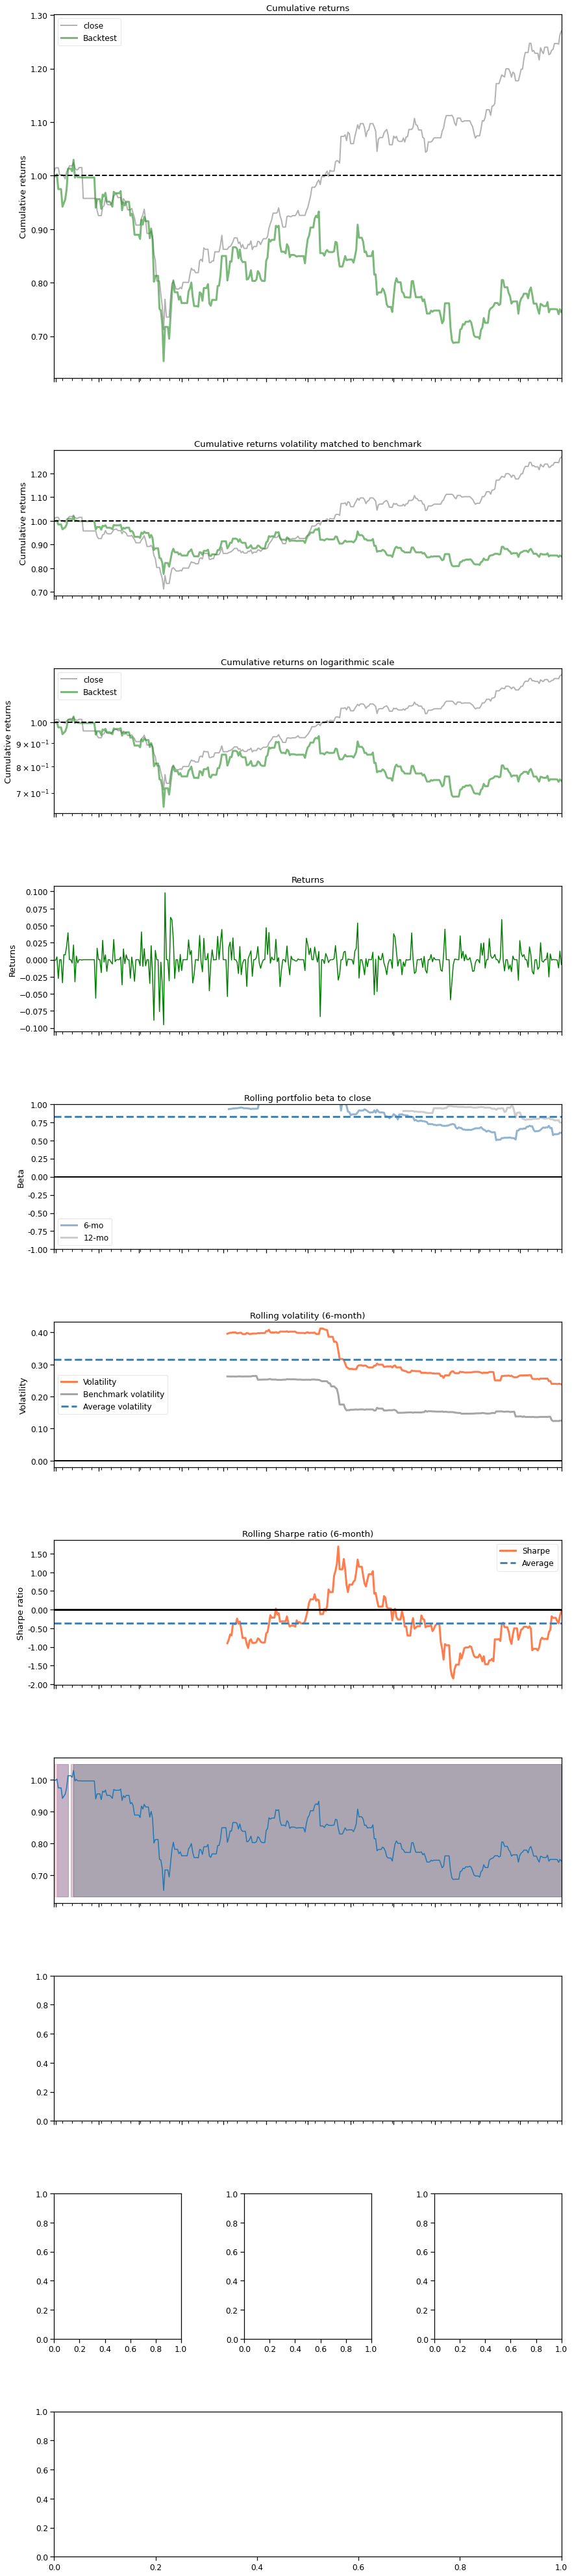

In [ ]:
print("==============Compare to 1101===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: 2330
# NASDAQ 100: ^NDX

# backtest_plot(df_account_value_ppo, 
#              baseline_ticker = '2330', 
#              baseline_start = '2019-01-01',
#              baseline_end = '2021-01-01')

# backtest_plot(df_account_value_ddpg, 
#              baseline_ticker = '2330', 
#              baseline_start = '2019-01-01',
#              baseline_end = '2021-01-01')
from copy import deepcopy
import pyfolio
account_value=df_account_value_ddpg,
baseline_start = '2019-12-31'
baseline_end = '2020-12-31'
baseline_ticker="0050",
value_col_name="account_value",
baseline_df = api.taiwan_stock_daily(
  stock_id='0050',
  start_date='2019-12-31',
  end_date='2020-12-31'
  )
baseline_df =baseline_df.rename(columns={
  'date':'date', # Date
  'stock_id':'tic', # Quarterly operating income
  'Trading_money':'volume', # Quartely revenue
  'max':'high', # Quartely net income
  'min':'low', # Assets
        })
baseline_df['date']=pd.to_datetime(baseline_df['date'])
baseline_df=baseline_df.set_index("date")
baseline_df=baseline_df.reindex(pd.date_range('2019-12-31','2020-12-31', freq ='D')).bfill()
df=pd.DataFrame(np.squeeze(account_value),columns=['date',"account_value"])
df["date"] = pd.to_datetime(df["date"])
test_returns = pd.Series(df["account_value"].pct_change(1)).bfill().set_axis(df["date"])
baseline_returns = pd.Series(baseline_df["close"].pct_change(1)).bfill().set_axis(baseline_df.index)
with pyfolio.plotting.plotting_context(font_scale=1.1):
  pyfolio.create_full_tear_sheet(
    returns=test_returns, benchmark_rets=baseline_returns, set_context=False
        )

#backtest_plot(df_account_value_a2c, 
#              baseline_ticker = '0050', 
#              baseline_start = '2019-12-31',
#              baseline_end = '2020-12-31')

# backtest_plot(df_account_value_td3, 
#              baseline_ticker = '2330', 
#              baseline_start = '2019-01-01',
#              baseline_end = '2021-01-01')

# backtest_plot(df_account_value_sac, 
#              baseline_ticker = '2330', 
#              baseline_start = '2019-01-01',
#              baseline_end = '2021-01-01')

In [ ]:
pd.Series(baseline_df["close"].pct_change(1)).bfill().set_axis(baseline_df.index)

2019-12-31    0.007220
2020-01-01    0.007220
2020-01-02    0.000000
2020-01-03    0.000000
2020-01-04   -0.012801
                ...   
2020-12-27    0.000000
2020-12-28    0.000000
2020-12-29   -0.000833
2020-12-30    0.014178
2020-12-31    0.005345
Freq: D, Name: close, Length: 367, dtype: float64

In [ ]:
baseline_df.reindex(pd.date_range('2019-12-31','2020-12-31', freq ='D')).bfill()

,tic,Trading_Volume,volume,open,high,low,close,spread,Trading_turnover
2019-12-31,0050,4303947.0,417657710.0,97.10,97.2,96.95,96.95,-0.85,1852.0
2020-01-01,0050,4882015.0,476649683.0,97.05,98.0,97.05,97.65,0.70,2421.0
2020-01-02,0050,4882015.0,476649683.0,97.05,98.0,97.05,97.65,0.70,2421.0
2020-01-03,0050,6813547.0,665657992.0,98.30,98.7,97.00,97.65,0.00,3080.0
2020-01-04,0050,9321768.0,901060879.0,97.05,97.1,96.40,96.40,-1.25,4809.0
...,...,...,...,...,...,...,...,...,...
2020-12-27,0050,3495974.0,418460860.0,119.05,120.0,119.05,120.00,1.05,4173.0
2020-12-28,0050,3495974.0,418460860.0,119.05,120.0,119.05,120.00,1.05,4173.0
2020-12-29,0050,3177140.0,380694787.0,120.05,120.2,119.35,119.90,-0.10,2824.0
2020-12-30,0050,5501727.0,664129018.0,120.00,121.6,119.90,121.60,1.70,4169.0


In [ ]:
baseline_df.set_index("date", inplace=True, drop=True)
pd.Series(baseline_df["close"].pct_change(1)).bfill().set_axis(baseline_df['date'])


KeyError: ignored

In [ ]:
pd.Series(df["account_value"].pct_change(1)).set_axis(df["date"])

date
2019-12-31         NaN
2020-01-01   -0.000091
2020-01-02   -0.000973
2020-01-03    0.000272
2020-01-04   -0.000079
                ...   
2020-12-27    0.000000
2020-12-28    0.016445
2020-12-29    0.009529
2020-12-30    0.020971
2020-12-31    0.001123
Name: account_value, Length: 367, dtype: float64

In [ ]:
df["account_value"].pct_change(1)

0           NaN
1     -0.000091
2     -0.000973
3      0.000272
4     -0.000079
         ...   
362    0.000000
363    0.016445
364    0.009529
365    0.020971
366    0.001123
Name: account_value, Length: 367, dtype: float64